# Group Connection Testing


In this notebook we will be testing whether the hemispheres/segments come from an stochastic block model, which models graphs containing communities, in which subsets of nodes within each community are characterized as being connected to each other with particular edge densities. Here, our communities are determined by the classes of the neurons within each hemisphere/segment, which we are considering can be interneuron, motorneuron, or sensory neuron.

In [1]:
import logging
import pandas as pd
import numpy as np
import csv
import networkx as nx
import itertools
import seaborn as sns
from pathlib import Path
from networkx import from_pandas_adjacency
from itertools import chain, combinations
from matplotlib import pyplot as plt
from collections import namedtuple
from graspologic.inference import group_connection_test
from graspologic.plot import heatmap, adjplot
from pkg.platy import _get_folder, load_connectome_normal_lcc_annotations_v2, load_left_adj, load_right_adj, load_head_adj, load_pygidium_adj, load_0_adj, load_1_adj, load_2_adj, load_3_adj


/Users/kareefullah/Library/Caches/pypoetry/virtualenvs/platy-data-EVeqgmAk-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
folder = _get_folder()
annotations = load_connectome_normal_lcc_annotations_v2()
folder

PosixPath('/Users/kareefullah/Desktop/NeuroData/neurodata/platy-data/docs/outputs')

The following blocks of code generate dataframes, where the skids_df represent the skids of interest in the hemispheres/segments and labels_df represent the corresponding labels of the classes of the neurons

In [3]:
#get indices from left and right
skids_hemis = {"left": [], "right": []}
skids_hemis_list = []
for key in skids_hemis:
    for i in range(len(annotations["skids"])):
        if annotations["side"][i] == key:
            skids_hemis[key].append(annotations["skids"][i])
            skids_hemis_list.append(annotations["skids"][i])
skids_hemis_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in skids_hemis.items()]))
#skids_hemis_df.to_csv(folder / "skids_hemis_v2.csv")
skids_hemis_df
            

,left,right
0,2015233,1646603.0
1,1548290,1769485.0
2,1318919,1622033.0
3,2015241,1064990.0
4,1318929,1441826.0
...,...,...
1350,1368040,NaN
1351,1277932,NaN
1352,1302513,NaN
1353,1630186,NaN


In [4]:
skids_hemis_with_class = {"left": [], "right": []}
labels_hemis_with_class = {"left": [], "right": []}
poss_labels = ["sensory", "inter", "motor", "muscle", "epithelia", "ciliated"]

#add skids and labels for hemis;
for key in skids_hemis_with_class:
    for i in range(len(annotations["skids"])):

        #check if the skid is in the left/right adj (normal, lcc), and the side is left or right, and the class exists as sensory, motor, or inter
        if(annotations["skids"][i] in skids_hemis_list and annotations["side"][i]==key and annotations["class"][i] in poss_labels):
            skids_hemis_with_class[key].append(annotations["skids"][i])
            labels_hemis_with_class[key].append(annotations["class"][i])

#convert dicts to dataframes
skids_hemis_with_class_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in skids_hemis_with_class.items()]))
labels_hemis_with_class_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in labels_hemis_with_class.items()]))
#skids_hemis_with_class_df.to_csv(folder / "skids_hemis_classes_v2.csv")
#labels_hemis_with_class_df.to_csv(folder / "labels_hemis_classes_v2.csv")

print(len(skids_hemis_with_class["left"]))
print(len(skids_hemis_with_class["right"]))

1226
1205


In [5]:
#get indices from left and right
skids_segs = {"head": [], "pygidium": [], "1": [], "2": [], "3": []}
skids_segs_list = []

for key in skids_segs:
    for i in range(len(annotations["skids"])):
        if annotations["segment"][i] == key:
            skids_segs[key].append(annotations["skids"][i])
            skids_segs_list.append(annotations["skids"][i])
skids_segs_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in skids_segs.items()]))
skids_segs_df.to_csv(folder / "skids_segs.csv")
skids_segs_df

,head,pygidium,1,2,3
0,2015233,1278185.0,1548290.0,1466405.0,1646603.0
1,1318919,1335777.0,1671212.0,1728563.0,1622033.0
2,2015241,1335790.0,1458234.0,1466424.0,1441826.0
3,1318929,1335832.0,1671231.0,1065030.0,1728550.0
4,1318938,1335845.0,1957973.0,1441872.0,1417265.0
...,...,...,...,...,...
918,393182,NaN,NaN,NaN,NaN
919,180202,NaN,NaN,NaN,NaN
920,1343467,NaN,NaN,NaN,NaN
921,1302513,NaN,NaN,NaN,NaN


In [6]:
skids_segs_with_class = {"head": [], "pygidium": [], "1": [], "2": [], "3": []}
labels_segs_with_class = {"head": [], "pygidium": [], "1": [], "2": [], "3": []}

for key in skids_segs:
    for i in range(len(annotations["skids"])):
        if(annotations["skids"][i] in skids_segs_list and annotations["segment"][i]==key and annotations["class"][i] in poss_labels):
            skids_segs_with_class[key].append(annotations["skids"][i])
            labels_segs_with_class[key].append(annotations["class"][i])

skids_segs_with_class_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in skids_segs_with_class.items()]))
labels_segs_with_class_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in labels_segs_with_class.items()]))
#skids_segs_with_class_df.to_csv(folder / "skids_segs_classes_v2.csv")
#labels_segs_with_class_df.to_csv(folder / "labels_segs_classes_v2.csv")
print(len(skids_segs_with_class["pygidium"]))

99


In [7]:
new_folder = Path.joinpath(folder, "group_connection_plots")
new_folder

PosixPath('/Users/kareefullah/Desktop/NeuroData/neurodata/platy-data/docs/outputs/group_connection_plots')

In [8]:
#comparison for hemis
count_hemis = {"left" : {"sensory": 0, "inter": 0, "motor": 0, "muscle": 0, "epithelia": 0, "ciliated": 0}, "right": {"sensory": 0, "inter": 0, "motor": 0, "muscle": 0, "epithelia": 0, "ciliated": 0}}

for key in count_hemis:
    for i in range(len(labels_hemis_with_class[key])):
        count_hemis[key][labels_hemis_with_class[key][i]] += 1

# get the lists of number of skids for y values, x values are the keys
keys = poss_labels # "sensory", "inter", "motor", "muscle", "epithelia", "ciliated"
list_counts_hemis = []
class_label_hemis = []
hemi_label = []
class_label_full = ["Sensory", "Inter", "Motor", "Muscle", "Epithelia", "Ciliated"]
# loop through "left" and "right"
for key in count_hemis:
    # loop through "sensory", "inter", "motor", "muscle", "epithelia", "ciliated"
    for inner_key in count_hemis[key]:
        # append "Sensory", "Inter", "Motor", "Muscle, "Epithelia", "Ciliated" depending on inner key
        for i in range(len(class_label_full)):
            if inner_key == class_label_full[i].lower():
                class_label_hemis.append(class_label_full[i])
        # add 1 to the count of the respective class label in the respective key of count_hemis
        list_counts_hemis.append(count_hemis[key][inner_key])
        # append the outer key from count_hemis
        hemi_label.append(key)

label_counts = list(zip(class_label_hemis, list_counts_hemis, hemi_label))
df_hemis = pd.DataFrame(label_counts, columns = ["class", "count", "side"])
#df_hemis.to_csv(new_folder / "hemi_classes_counts_v2.csv")
df_hemis

,class,count,side
0,Sensory,283,left
1,Inter,478,left
2,Motor,108,left
3,Muscle,255,left
4,Epithelia,65,left
5,Ciliated,37,left
6,Sensory,272,right
7,Inter,497,right
8,Motor,121,right
9,Muscle,227,right


We make barplots for the counts of each of the classes across the hemispheres/segments using the dictionaries we generated above

Text(0.5, 1.0, 'counts of classes across hemis')

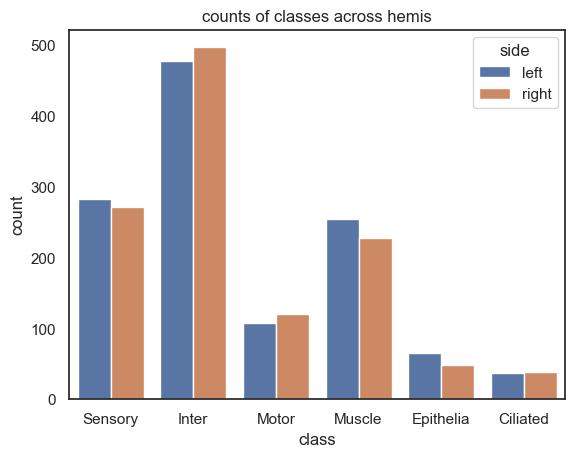

In [9]:
sns.set(style="white")
sns.barplot(x="class", y="count", hue="side", data=df_hemis)
plt.title("counts of classes across hemis")
#plt.savefig(new_folder / "hemi_classes_barplot_v2.png")

In [10]:

#comparison for segments
count_segs = {"head" : {"sensory": 0, "inter": 0, "motor": 0, "muscle": 0, "epithelia": 0, "ciliated": 0},
              "pygidium": {"sensory": 0, "inter": 0, "motor": 0, "muscle": 0, "epithelia": 0, "ciliated": 0},
              "1" : {"sensory": 0, "inter": 0, "motor": 0, "muscle": 0, "epithelia": 0, "ciliated": 0},
              "2" : {"sensory": 0, "inter": 0, "motor": 0, "muscle": 0, "epithelia": 0, "ciliated": 0},
              "3" : {"sensory": 0, "inter": 0, "motor": 0, "muscle": 0, "epithelia": 0, "ciliated": 0},}

for key in count_segs:
    for i in range(len(labels_segs_with_class[key])):
        count_segs[key][labels_segs_with_class[key][i]] += 1

# get the lists of number of skids for y values, x values are the keys
keys = poss_labels # "sensory", "inter", "motor", "muscle", "epithelia", "ciliated"
list_counts_segs = []
class_label_segs = []
segs_label = []
# loop through segments
for key in count_segs:
    # loop through inner keys
    for inner_key in count_segs[key]:
        # append "Sensory", "Inter", "Motor", "Muscle", "Epithelia", "Ciliated" depending on inner key
        for i in range(len(class_label_full)):
            if inner_key == class_label_full[i].lower():
                class_label_segs.append(class_label_full[i])
        # add 1 to the count of the respective class label in the respective key of count_hemis
        list_counts_segs.append(count_segs[key][inner_key])
        # append the outer key from count_hemis
        segs_label.append(key)

label_counts_segs = list(zip(class_label_segs, list_counts_segs, segs_label))
df_segs = pd.DataFrame(label_counts_segs, columns = ["class", "count", "segment"])
#df_segs.to_csv(new_folder / "segs_classes_counts_v2.csv")
df_segs

,class,count,segment
0,Sensory,375,head
1,Inter,432,head
2,Motor,20,head
3,Muscle,13,head
4,Epithelia,16,head
5,Ciliated,34,head
6,Sensory,44,pygidium
7,Inter,18,pygidium
8,Motor,2,pygidium
9,Muscle,6,pygidium


Text(0.5, 1.0, 'counts of classes across segments')

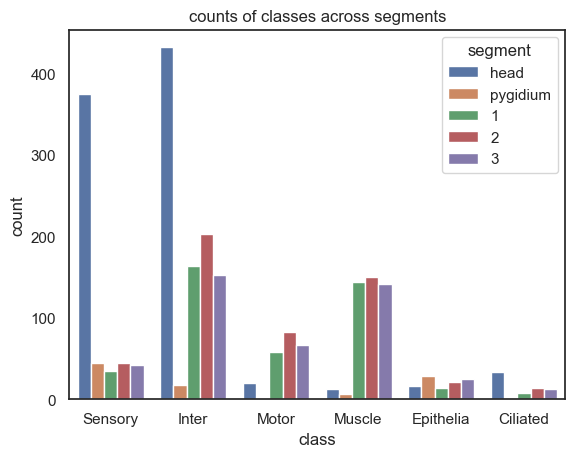

In [11]:
sns.set(style="white")
sns.barplot(x="class", y="count", hue="segment", data=df_segs)
plt.title("counts of classes across segments")
#plt.savefig(new_folder / "segs_classes_barplot.png")

We will now visualize the adjs of the hemispheres/segments, in which the nodes will be grouped into communities of sensory, motor, or interneurons

In [12]:
#block for loading adjs/labels
from pkg.platy import load_left_adj_labels_with_class_v2, load_right_adj_labels_with_class_v2, load_head_adj_labels_with_class_v2, load_pygidium_adj_labels_with_class_v2, load_1_adj_labels_with_class_v2, load_2_adj_labels_with_class_v2, load_3_adj_labels_with_class_v2
#hemis
left_adj, left_labels = load_left_adj_labels_with_class_v2()
right_adj, right_labels = load_right_adj_labels_with_class_v2()

#segments
head_adj, head_labels = load_head_adj_labels_with_class_v2()
pyg_adj, pyg_labels = load_pygidium_adj_labels_with_class_v2()
#adj_0, labels_0 = load_0_adj_labels()
adj_1, labels_1 = load_1_adj_labels_with_class_v2()
adj_2, labels_2 = load_2_adj_labels_with_class_v2()
adj_3, labels_3 = load_3_adj_labels_with_class_v2()

In [13]:
#lists for adjs/labels/names
hemi_adjs = [left_adj, right_adj]
for i, val in enumerate(hemi_adjs):
    hemi_adjs[i] = val.to_numpy()

segment_adjs = [head_adj, pyg_adj, adj_1, adj_2, adj_3]
for i, val in enumerate(segment_adjs):
    segment_adjs[i] = val.to_numpy()
all_adjs = hemi_adjs + segment_adjs

hemi_labels = [left_labels, right_labels]
segment_labels = [head_labels, pyg_labels, labels_1, labels_2, labels_3]
all_labels = hemi_labels + segment_labels

hemi_names = ["left", "right"]
segment_names = ["head", "pygidium", "1", "2", "3"]
all_names = hemi_names + segment_names

count = 0
for i in range(len(all_labels[0])):
    if(all_labels[0][i] == "muscle"):
        count += 1

count

255

227


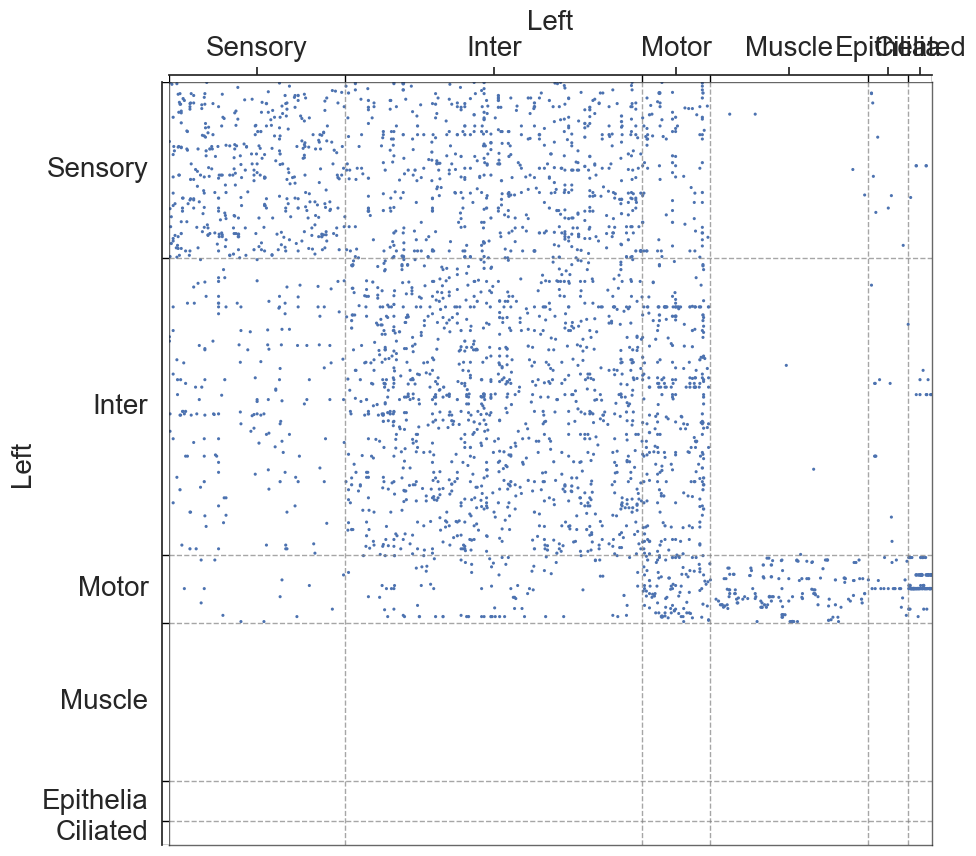

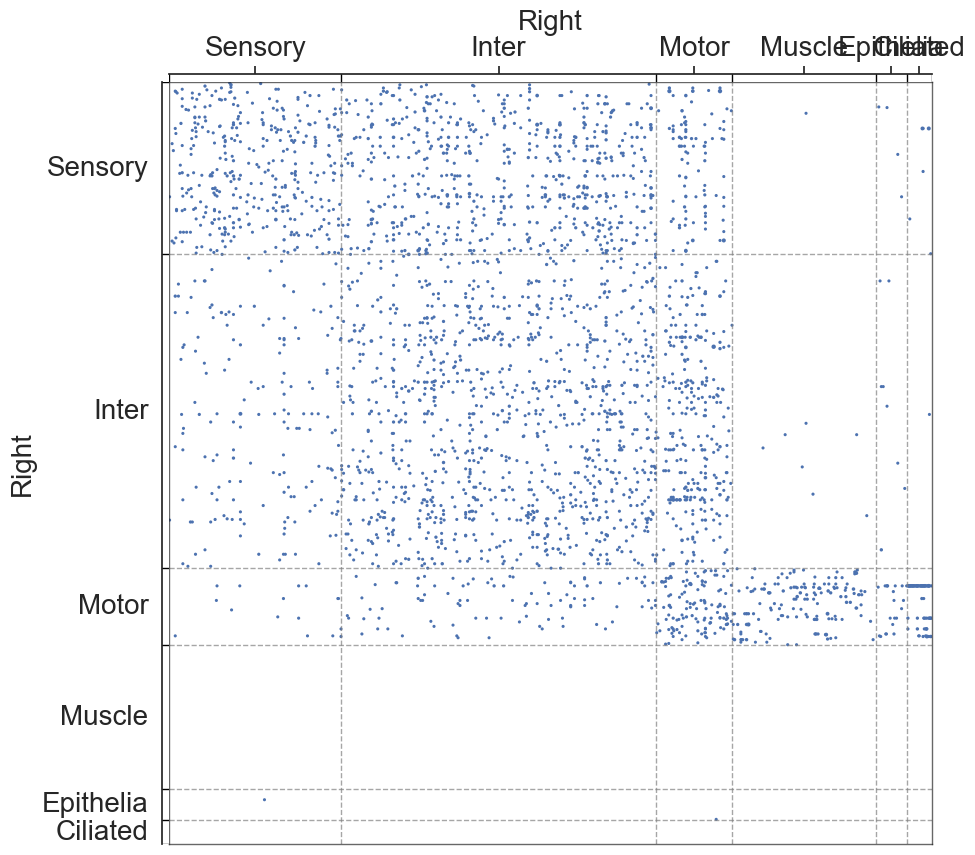

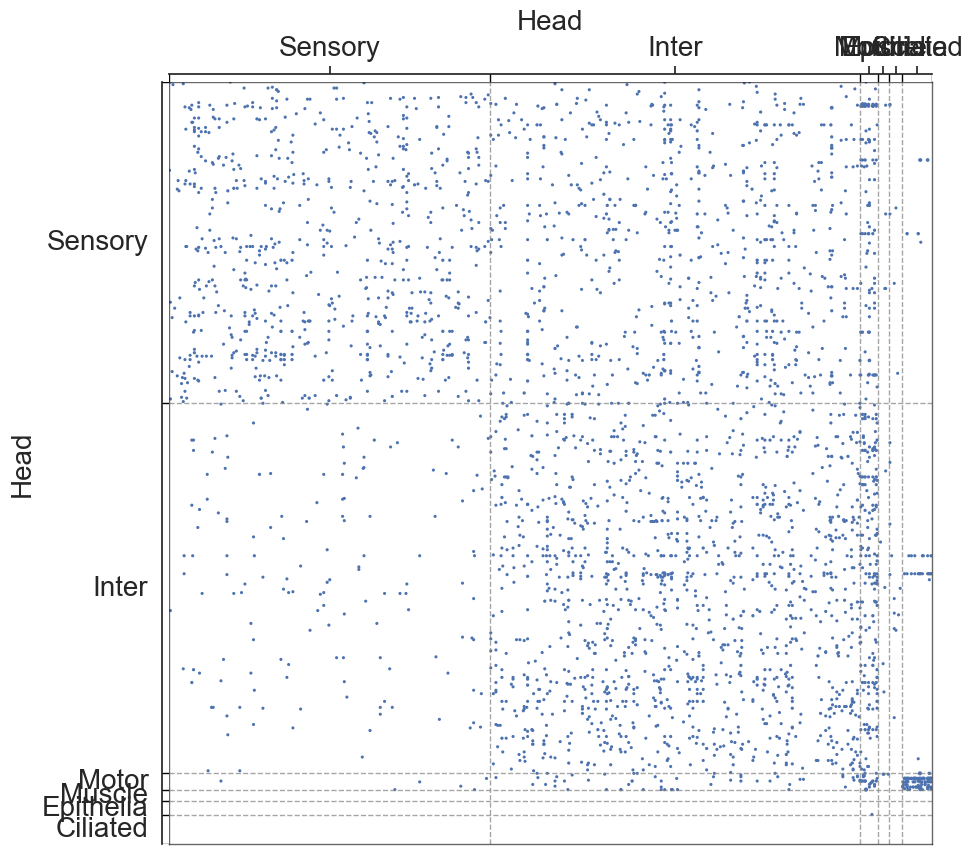

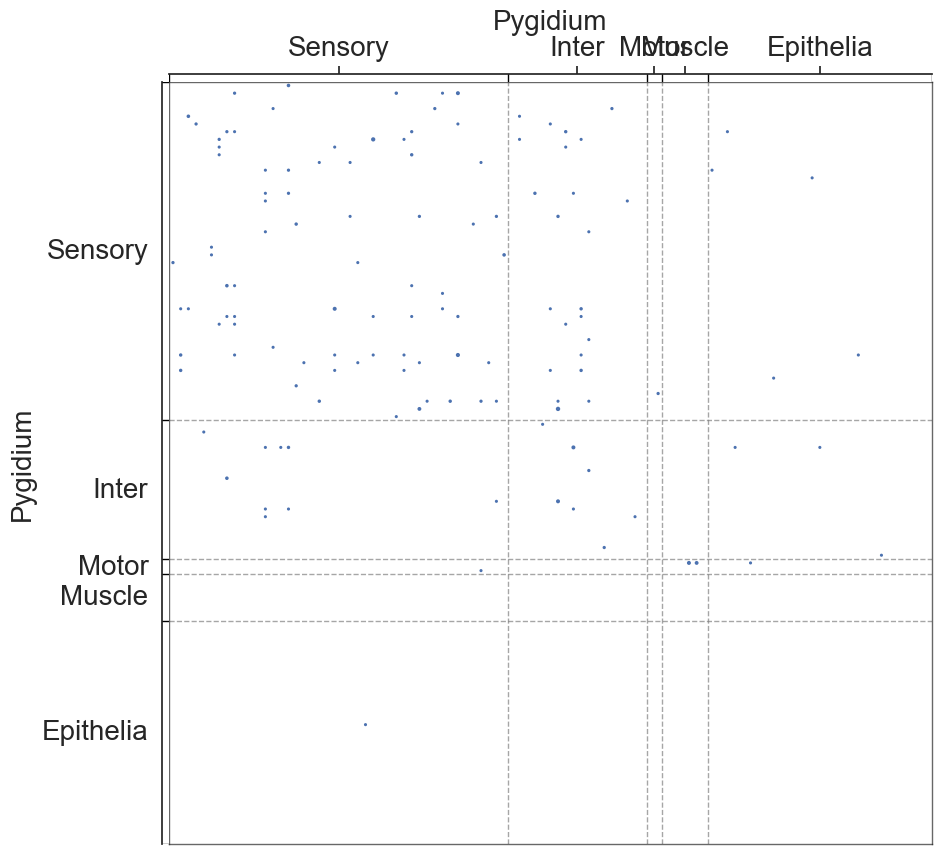

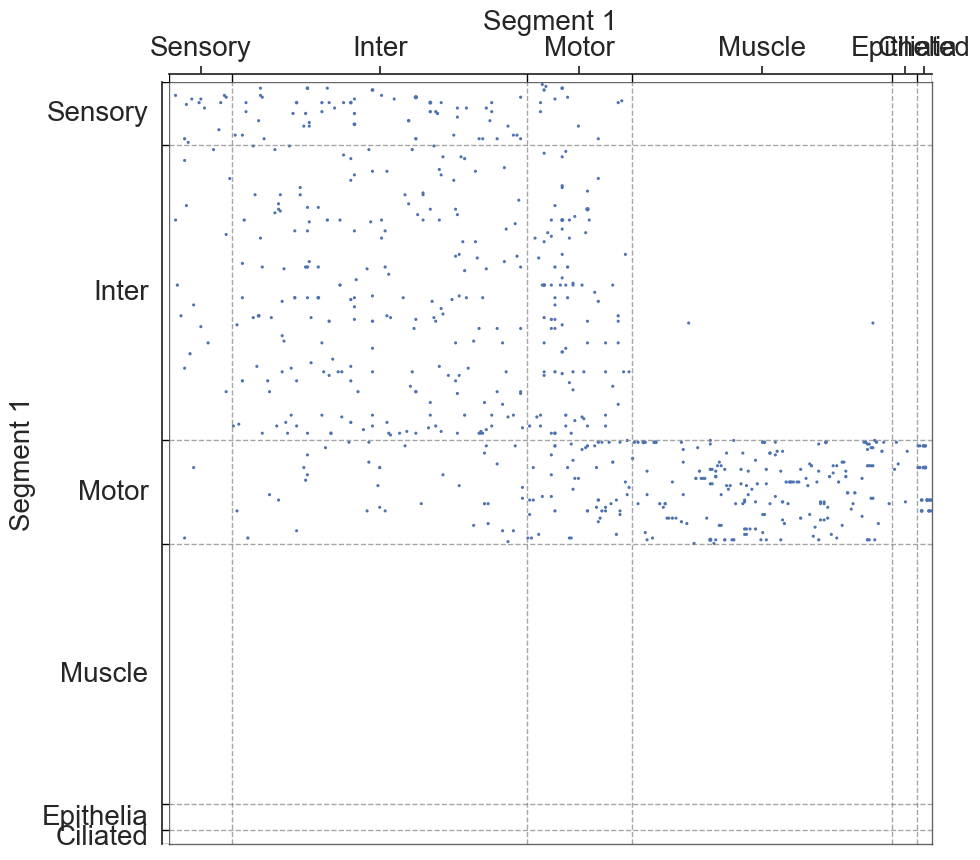

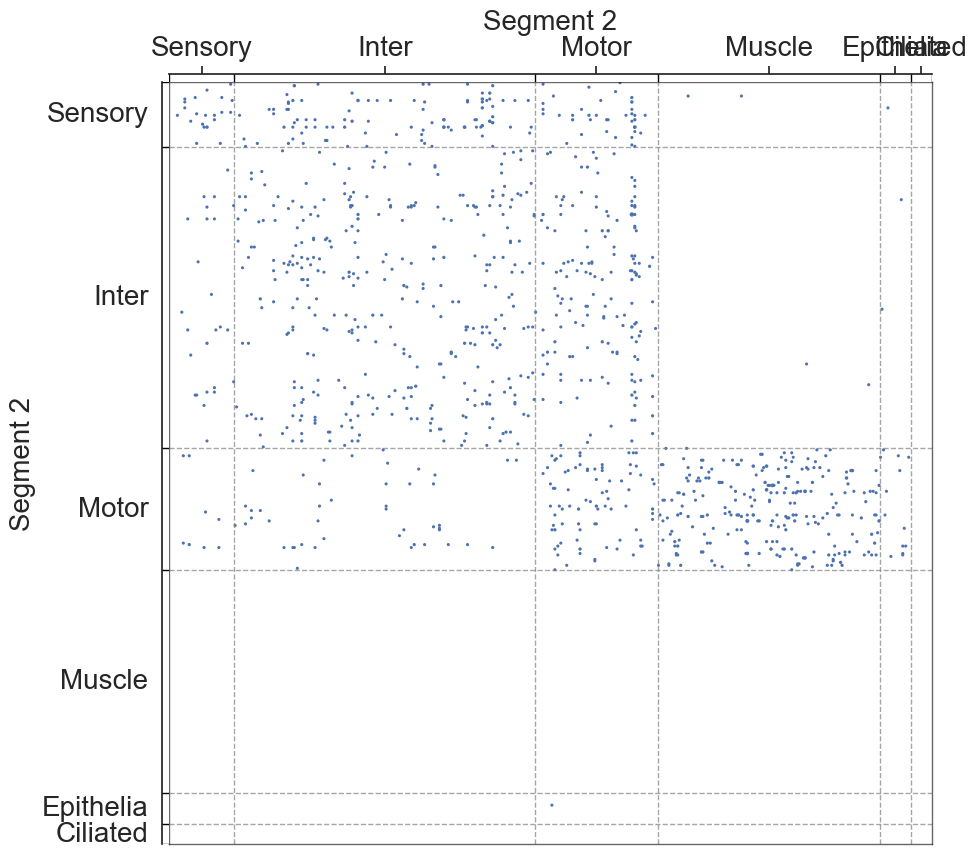

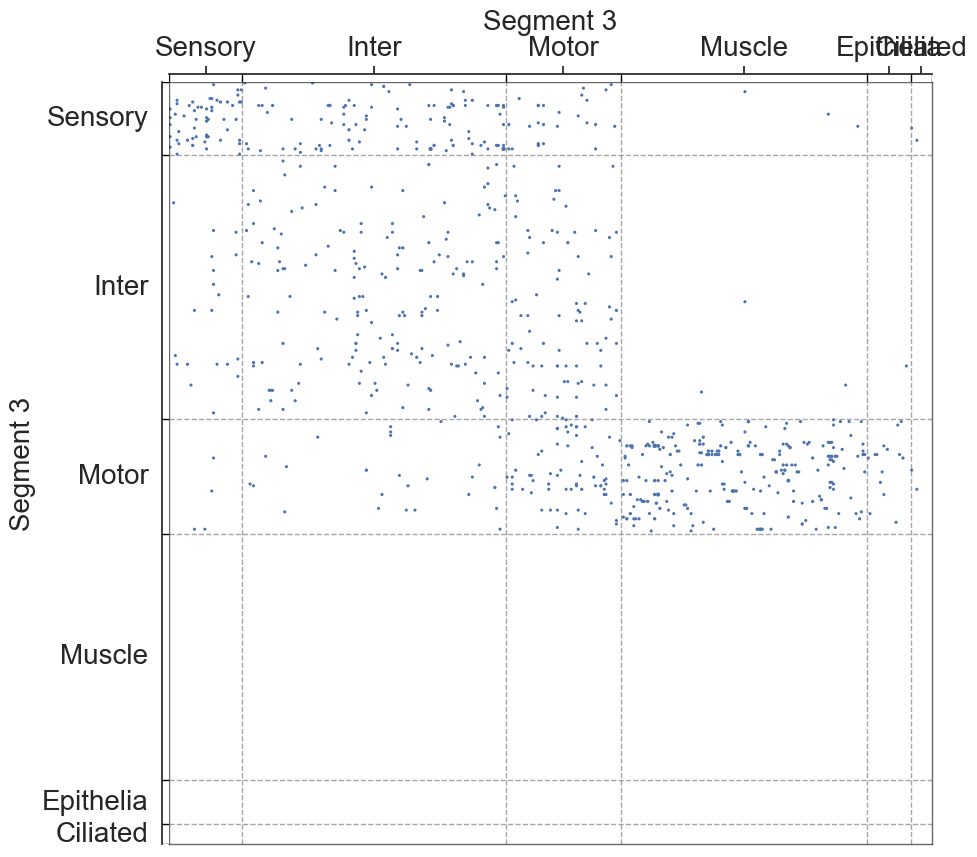

In [14]:
#scatterplots

#format segment names
all_names_format = []
for i in range(len(all_names)):
    if(all_names[i].isnumeric()):
        all_names_format.append(f"Segment {all_names[i]}")

    else:
        all_names_format.append(all_names[i].capitalize())
#metadata
metas = []
for i in range(len(all_adjs)):

    label_list = []
    order_list = []
    for j in range(len(all_labels[i])):

        if all_labels[i][j] == "sensory":
            label_list.append("Sensory")
            order_list.append(0)

        elif all_labels[i][j] == "inter":
            label_list.append("Inter")
            order_list.append(1)
        
        elif all_labels[i][j] == "motor":
            label_list.append("Motor")
            order_list.append(2)
        
        elif all_labels[i][j] == "muscle":
            label_list.append("Muscle")
            order_list.append(3)
        
        elif all_labels[i][j] == "epithelia":
            label_list.append("Epithelia")
            order_list.append(4)
        
        elif all_labels[i][j] == "ciliated":
            label_list.append("Ciliated")
            order_list.append(5)



    metas.append(pd.DataFrame(
        data={
              "{}".format(all_names_format[i]): label_list,
              "{}_order".format(all_names_format[i]): order_list
        },
))
count = 0
for i in range(len(metas[1]["Right"])):
    if(metas[1]["Right"][i] == "Muscle"):
        count += 1
print(count)

for i in range(len(all_adjs)):
    #group_order parameter - make all s have group order 0 etc
    adjplot(all_adjs[i], plot_type="scattermap", meta=metas[i], group=["{}".format(all_names_format[i])], group_order=["{}_order".format(all_names_format[i])])
    #plt.savefig(new_folder / "scatterplots" / "connection_{}".format(all_names[i]))


In [15]:
print(len(metas[3]))
print(len(all_adjs[3]))

99
99


Group Connection Test for Left and Right Hemispheres

In [16]:
stat, pval, misc = group_connection_test(hemi_adjs[0], hemi_adjs[1], hemi_labels[0], hemi_labels[1])
pval

0.14754884074246316

We do the same for all the pairwise combinations of segments

In [17]:
#get rid of pygidium in analysis since it does not have epithlia or ciliated
segment_adjs = [head_adj, adj_1, adj_2, adj_3]
segment_labels = [head_labels, labels_1, labels_2, labels_3]
segment_names = ["head", "1", "2", "3"]

pairwise_labels = list(itertools.combinations(segment_labels, 2))
pairwise_adjs = list(itertools.combinations(segment_adjs, 2))
pairwise_names = list(itertools.combinations(segment_names, 2))
#initialize dataframe
zero_data = np.zeros(shape=(len(segment_names), len(segment_names)))
pval_df = pd.DataFrame(zero_data, columns=segment_names, index=segment_names)
pval_list = []

thres = 1e-12

for label, adjs, name in zip(pairwise_labels, pairwise_adjs, pairwise_names):
    np_adj0 = np.array(adjs[0])
    np_adj1 = np.array(adjs[1])
    stat, pval, misc = group_connection_test(np_adj0, np_adj1, label[0], label[1])
    #lower limit
    if pval<thres:
        pval = thres
    
    pval_df[name[0]][name[1]] = pval
    pval_df[name[1]][name[0]] = pval

pval_df.to_csv(new_folder  / "group_connection_test_pvals_segments_v2.csv")
pval_df

,head,1,2,3
head,0.000000e+00,1.826661e-07,1.084669e-10,1.000000e-12
1,1.826661e-07,0.000000e+00,6.046471e-01,2.177351e-04
2,1.084669e-10,6.046471e-01,0.000000e+00,2.719751e-04
3,1.000000e-12,2.177351e-04,2.719751e-04,0.000000e+00


Let's use bonferroni's correction on the segment p-values to reduce the chances of obtaining false positive results since we are using multiple pairwise tests

In [18]:
#bonferroni correction for non-density adjusted p-vals
from statsmodels.stats.multitest import multipletests
np_pvals = pval_df.to_numpy().flatten()
corrected_pvals = multipletests(np_pvals)[1].reshape((len(segment_names), len(segment_names)))
pvals_df_bonferroni_corrected = pd.DataFrame(corrected_pvals, columns=segment_names, index=segment_names)
pvals_df_bonferroni_corrected

,head,1,2,3
head,0.000000e+00,0.000001,1.084669e-09,1.200000e-11
1,1.461328e-06,0.000000,8.436961e-01,1.305700e-03
2,1.084669e-09,0.843696,0.000000e+00,1.305700e-03
3,1.200000e-11,0.001306,1.305700e-03,0.000000e+00


Now, let's use the density adjusted version of group connection tests, which accounts for the potential difference in density across the adjs (are the group-to-group connection probabilities of one adj simply a scaled-up version of those of the other)

In [19]:
stat, pval, misc = group_connection_test(hemi_adjs[0], hemi_adjs[1], hemi_labels[0], hemi_labels[1], density_adjustment=True)
pval

0.010562074036869092

In [20]:
pairwise_labels = list(itertools.combinations(segment_labels, 2))
pairwise_adjs = list(itertools.combinations(segment_adjs, 2))
pairwise_names = list(itertools.combinations(segment_names, 2))
#initialize dataframe
zero_data = np.zeros(shape=(len(segment_names), len(segment_names)))
pval_df_density_correct = pd.DataFrame(zero_data, columns=segment_names, index=segment_names)
pval_list = []
for label, adjs, name in zip(pairwise_labels, pairwise_adjs, pairwise_names):
    np_adj0 = np.array(adjs[0])
    np_adj1 = np.array(adjs[1])
    stat, pval, misc = group_connection_test(np_adj0, np_adj1, label[0], label[1], density_adjustment=True)

    #lower limit
    if pval<thres:
        pval = thres
        
    pval_df_density_correct[name[0]][name[1]] = pval
    pval_df_density_correct[name[1]][name[0]] = pval
pval_df_density_correct.to_csv(folder / "group_connection_plots" / "group_connection_test_pvals_segments_density_adjust_v2.csv")
pval_df_density_correct

,head,1,2,3
head,0.000000e+00,2.740040e-07,3.021355e-10,1.000000e-12
1,2.740040e-07,0.000000e+00,5.137032e-01,9.263719e-05
2,3.021355e-10,5.137032e-01,0.000000e+00,2.593426e-04
3,1.000000e-12,9.263719e-05,2.593426e-04,0.000000e+00


Using Bonferroni's correction for the density adjusted segments:

In [21]:
np_pvals_density_correct = pval_df_density_correct.to_numpy().flatten()
corrected_pvals_density_correct = multipletests(np_pvals_density_correct)[1].reshape((len(segment_names), len(segment_names)))
pvals_df_density_corrected_bonferroni_corrected = pd.DataFrame(corrected_pvals_density_correct, columns=segment_names, index=segment_names)
pvals_df_density_corrected_bonferroni_corrected

,head,1,2,3
head,0.000000e+00,0.000002,3.021355e-09,1.200000e-11
1,2.192030e-06,0.000000,7.635154e-01,5.556944e-04
2,3.021355e-09,0.763515,0.000000e+00,1.036967e-03
3,1.200000e-11,0.000556,1.036967e-03,0.000000e+00


The following functions will allow us to visualize the p-values of the segments in a heatmap, where significant p-values are denoted with an X

In [22]:
from matplotlib.transforms import Bbox
def shrink_axis(ax, scale=0.7, shift=0):
    pos = ax.get_position()
    mid = (pos.ymax + pos.ymin) / 2
    height = pos.ymax - pos.ymin
    new_pos = Bbox(
        [
            [pos.xmin, mid - scale * 0.5 * height - shift],
            [pos.xmax, mid + scale * 0.5 * height - shift],
        ]
    )
    ax.set_position(new_pos)

In [23]:
import matplotlib as mpl
#cmap = mpl.colormaps["RdBu"]

In [147]:
from seaborn.utils import relative_luminance
from pkg.plot import bound_texts
import matplotlib as mpl
def plot_pvals(df, names, density_correct=True, bonferroni_correct=False, ax=None, thres=None, title=None, check_diag = False):
    if ax is None:
        width_ratios = [0.5, 3, 10]
        fig, axs = plt.subplots(
            1,
            3,
            figsize=(10, 10),
            gridspec_kw=dict(
                width_ratios=width_ratios,
            ),
        )
        axs[1].remove()
        ax = axs[-1]
        cax = axs[0]
    
    #take the log10 of all the pvals
    plot_pvalues = np.log10(df)
    plot_pvalues.replace(-np.inf, 0, inplace=True)
    im = sns.heatmap(
        plot_pvalues,
        ax=ax,
        cmap="RdBu",
        center=0,
        square=True,
        cbar=False,
        vmin=np.log10(thres),
        fmt="s",
    )

    if title is not None:
        title = title
    else:
        title = "Group Connection p-values segments"
        if density_correct == True:
            title += " (density adjusted)"

        if bonferroni_correct == True:
            title += " (bonferroni)"

    ax.set(ylabel="Source group", xlabel="Target group", title=title)
    ax.set(xticks=np.arange(len(names)) + 0.5, xticklabels=names)
    
    colors = im.get_children()[0].get_facecolors()
    #print(colors)
    shrink_axis(cax, scale=0.5, shift=0.05)
    
    fig = ax.get_figure()

    
    if thres is None:
        cb = fig.colorbar(
            im.get_children()[0],
            cax=cax,
            fraction=1,
            shrink=1,
            ticklocation="left",
        )

    else:
        
        cb = fig.colorbar(
            im.get_children()[0],
            cax=cax,
            fraction=1,
            shrink=1,
            ticks=np.linspace(np.log10(thres), 0, 4), #[-12, -8, -4, 0]
            ticklocation="left",
        )
        
        
        """
        cmap = mpl.cm.RdBu
        vmax=0
        vmin=np.log10(thres)
        center=0
        vrange = max(vmax - center, center - vmin)
        normlize = mpl.colors.Normalize(center - vrange, center + vrange)
        cmin, cmax = normlize([vmin, vmax])
        cc = np.linspace(cmin, cmax, 256)
        cmap = mpl.colors.ListedColormap(cmap(cc))

        fig.colorbar(mpl.cm.ScalarMappable(norm=normlize, cmap=cmap),
        cax=cax, orientation='vertical')
        """
        
        texts = []
        texts.append(ax.text(-0.6, -0.15, "log10 p-val thres", transform=ax.transAxes))
        texts.append(ax.text(-0.6, -0.23, f"of {np.log10(thres)}", transform=ax.transAxes))
        
        bound_texts(
            texts, ax=ax, facecolor="white", edgecolor="lightgrey", xpad=0.2, ypad=0.4
        )
    
    cax.set_title(r"$log_{10}$" + "\ncorrected" "\np-value", pad=20)
    
    cax.plot(
        [0, 1], [np.log10(0.05), np.log10(0.05)], zorder=100, color="black", linewidth=3
    )
    
    cax.annotate(
        r"$\alpha$",
        (0.05, np.log10(0.05)),
        xytext=(-5, 0),
        textcoords="offset points",
        va="center",
        ha="right",
        arrowprops={"arrowstyle": "-", "linewidth": 3, "relpos": (0, 0.5)},
    )
    
    #make X's
    pad=0.2
    for idx, color in enumerate(colors):
        i, j = np.unravel_index(idx, (len(names), len(names)))
        if check_diag == False:
            if i!=j and np.log(df.loc[names[j], names[i]]) < np.log(0.05):
                lum = relative_luminance(color)
                text_color = ".15" if lum > 0.408 else "w"

                xs = [j + pad, j + 1 - pad]
                ys = [i + pad, i + 1 - pad]
                ax.plot(xs, ys, color=text_color, linewidth=4)
                xs = [j + 1 - pad, j + pad]
                ys = [i + pad, i + 1 - pad]
                ax.plot(xs, ys, color=text_color, linewidth=4)
        """
        else:
            #index correctly using loc
            if np.log(df.loc[names[j], names[i]]) < np.log(0.05):
                print(f'{df.loc[names[j], names[i]]}, {np.log(df.loc[names[j], names[i]])}')
                print("{}, {}".format(names[i], names[j]))
                print()
                lum = relative_luminance(color)
                text_color = ".15" if lum > 0.408 else "w"

                xs = [j + pad, j + 1 - pad]
                ys = [i + pad, i + 1 - pad]
                ax.plot(xs, ys, color=text_color, linewidth=4)
                xs = [j + 1 - pad, j + pad]
                ys = [i + pad, i + 1 - pad]
                ax.plot(xs, ys, color=text_color, linewidth=4)
        """
    

/Users/kareefullah/Library/Caches/pypoetry/virtualenvs/platy-data-EVeqgmAk-py3.9/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


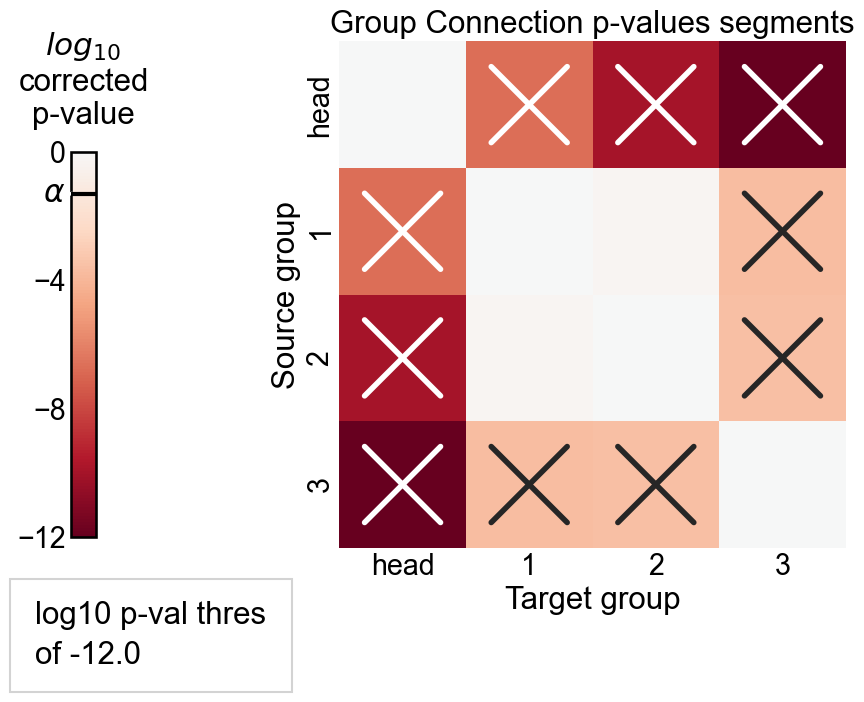

In [148]:
plot_pvals(df=pval_df, names=segment_names, density_correct=False, bonferroni_correct=False, thres=thres)
#plt.savefig(new_folder / "group_connection_heatmap_segments_v2")

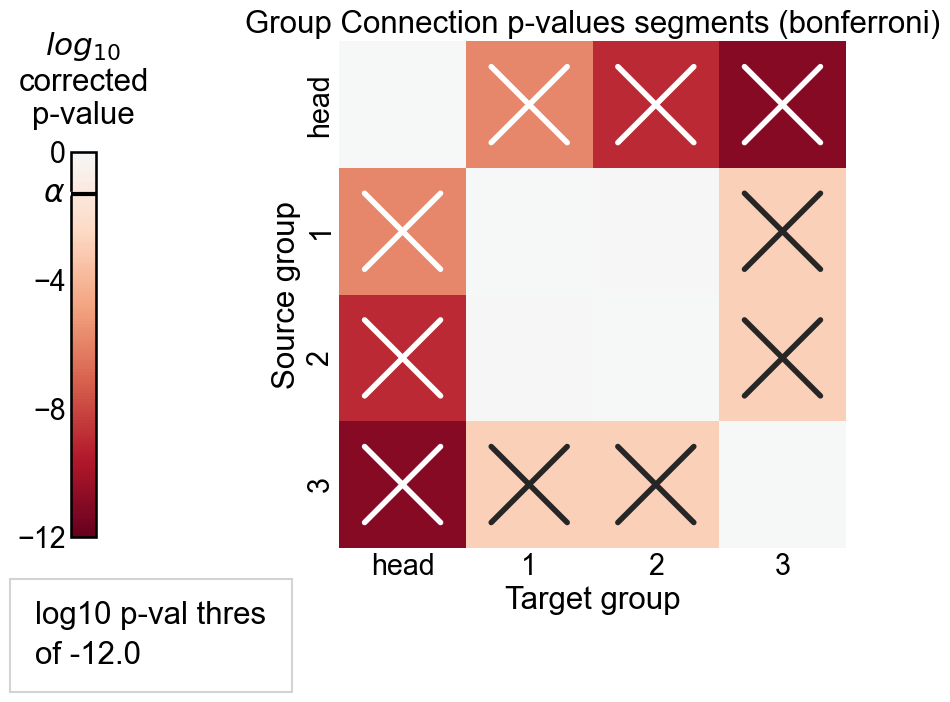

In [149]:
plot_pvals(df=pvals_df_bonferroni_corrected, names=segment_names, density_correct=False, bonferroni_correct=True, thres=thres)
#plt.savefig(new_folder / "group_connection_heatmap_segments_bonferroni_corrected_v2")

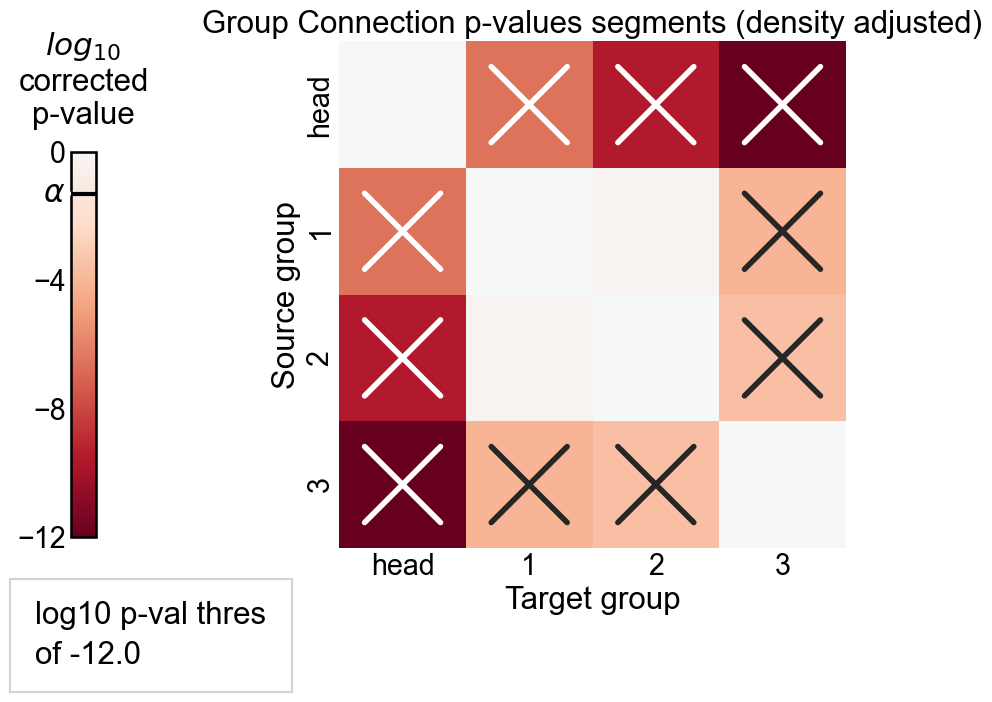

In [89]:
plot_pvals(df=pval_df_density_correct, names=segment_names, density_correct=True, thres=thres)
#plt.savefig(new_folder / "group_connection_heatmap_segments_density_adjusted_v2")

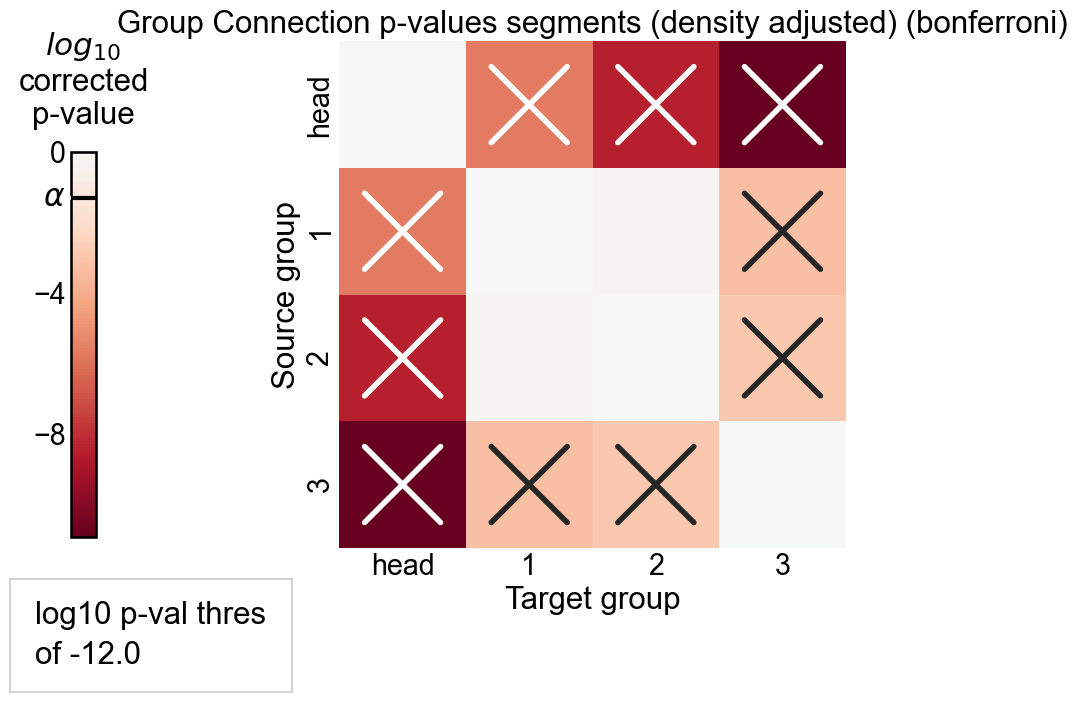

In [90]:
plot_pvals(df=pvals_df_density_corrected_bonferroni_corrected, names=segment_names, density_correct=True, bonferroni_correct=True, thres=thres)
#plt.savefig(new_folder / "group_connection_heatmap_segments_density_adjusted_bonferroni_corrected_v2")

The following section will look at comparisons of the B matrices of left vs right, and of the head, seg 1, and seg 2 using the density adjusted test

In [30]:
from pkg.plot import plot_stochastic_block_probabilities, set_theme, bound_texts
from pkg.data import load_network_palette, load_node_palette, load_unmatched
neutral_color = sns.color_palette("Set2")[2]
network_palette, NETWORK_KEY = load_network_palette()

In [31]:
def plot_stochastic_block_probabilities(misc, network_palette, name1, name2):
    # get values
    B1 = misc["probabilities1"]
    B2 = misc["probabilities2"]
    null_odds = misc["null_ratio"]
    B2 = B2 * null_odds

    p_max = max(B1.values.max(), B2.values.max())
    K = B1.shape[0]

    # set up plot
    pad = 2
    width_ratios = [0.5, pad + 0.8, 10, pad, 10]
    set_theme(font_scale=1.25)
    fig, axs = plt.subplots(
        1,
        len(width_ratios),
        figsize=(20, 10),
        gridspec_kw=dict(
            width_ratios=width_ratios,
        ),
    )
    left_col = 2
    right_col = 4
    # pvalue_col = 6

    heatmap_kws = dict(
        cmap="Blues", square=True, cbar=False, vmax=p_max, fmt="s", xticklabels=True
    )

    # heatmap of left connection probabilities
    annot = np.full((K, K), "")
    annot[B1.values == 0] = 0
    ax = axs[left_col]
    sns.heatmap(B1, ax=ax, annot=annot, **heatmap_kws)
    ax.set(ylabel="Source group", xlabel="Target group")
    first_text = r"$\hat{B}$ "
    first_text = first_text + name1
    ax.set_title(first_text, fontsize="xx-large", color=network_palette["Left"])

    # heatmap of right connection probabilities
    annot = np.full((K, K), "")
    annot[B2.values == 0] = 0
    ax = axs[right_col]
    im = sns.heatmap(B2, ax=ax, annot=annot, **heatmap_kws)
    ax.set(ylabel="", xlabel="Target group")
    second_text = r"$\hat{B}$ "
    second_text = second_text + name2
    if null_odds != 1:
        second_text = r"$c$" + second_text
    ax.set_title(second_text, fontsize="xx-large", color=network_palette["Right"])
    # ax.set(yticks=[], yticklabels=[])

    # handle the colorbars
    # NOTE: did it this way cause the other options weren't playing nice with auto
    # constrain
    # layouts.

    ax = axs[0]
    shrink_axis(ax, scale=0.5)
    _ = fig.colorbar(
        im.get_children()[0],
        cax=ax,
        fraction=1,
        shrink=1,
        ticklocation="left",
    )
    ax.set_title("Estimated\nedge\nprobability", y=1.1)

    # remove dummy axes
    for i in range(len(width_ratios)):
        if not axs[i].has_data():
            axs[i].set_visible(False)

    ax = axs[left_col]
    
    """
    texts = []
    texts.append(ax.text(-0.6, -0.15, "0 - No edges", transform=ax.transAxes))
    texts.append(ax.text(-0.51, -0.23, "observed", transform=ax.transAxes))

    bound_texts(
        texts, ax=ax, facecolor="white", edgecolor="lightgrey", xpad=0.2, ypad=0.8
    )
    """

    return fig, axs

In [32]:
def plot_estimated_probabilities(misc, name1, name2):
    B1 = misc["probabilities1"]
    B2 = misc["probabilities2"]
    null_odds = misc["null_ratio"]
    B2 = B2 * null_odds
    B1_ravel = B1.values.ravel()
    B2_ravel = B2.values.ravel()
    arange = np.arange(len(B1_ravel))
    sum_ravel = B1_ravel + B2_ravel
    sort_inds = np.argsort(-sum_ravel)
    B1_ravel = B1_ravel[sort_inds]
    B2_ravel = B2_ravel[sort_inds]

    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    ax = axs[0]
    sns.scatterplot(
        x=arange,
        y=B1_ravel,
        color=network_palette["Left"],
        ax=ax,
        linewidth=0,
        s=15,
        alpha=0.5,
    )
    sns.scatterplot(
        x=arange,
        y=B2_ravel,
        color=network_palette["Right"],
        ax=ax,
        linewidth=0,
        s=15,
        alpha=0.5,
        zorder=-1,
    )
    ax.text(
        0.7,
        0.8,
        f"{name1}",
        color=network_palette["Left"],
        transform=ax.transAxes,
    )
    ax.text(
        0.7,
        0.7,
        f"{name2}",
        color=network_palette["Right"],
        transform=ax.transAxes,
    )
    ax.set_yscale("log")
    ax.set(
        ylabel="Estimated probability " + r"($\hat{p}$)",
        xticks=[],
        xlabel="Sorted group pairs",
    )
    ax.spines["bottom"].set_visible(False)

    ax = axs[1]
    diff = B1_ravel - B2_ravel
    yscale = np.max(np.abs(diff))
    yscale *= 1.05
    sns.scatterplot(
        x=arange, y=diff, ax=ax, linewidth=0, s=25, color=neutral_color, alpha=1
    )
    ax.axhline(0, color="black", zorder=-1)
    ax.spines["bottom"].set_visible(False)
    ax.set(
        xticks=[],
        ylabel=r"$\hat{p}_{left} - \hat{p}_{right}$",
        xlabel="Sorted group pairs",
        ylim=(-yscale, yscale),
    )
    n_greater = np.count_nonzero(diff > 0)
    n_total = len(diff)
    ax.text(
        0.3,
        0.8,
        f"{name1} connection stronger ({n_greater}/{n_total})",
        color=network_palette["Left"],
        transform=ax.transAxes,
    )
    n_lesser = np.count_nonzero(diff < 0)
    ax.text(
        0.3,
        0.15,
        f"{name2} connection stronger ({n_lesser}/{n_total})",
        color=network_palette["Right"],
        transform=ax.transAxes,
    )

    fig.text(0.02, 0.905, "A)", fontweight="bold", fontsize=30)
    fig.text(0.02, 0.49, "B)", fontweight="bold", fontsize=30)

    return fig, ax

In [142]:
from seaborn.utils import relative_luminance
from pkg.plot import bound_texts
import matplotlib as mpl
def plot_pvals_v2(df, density_correct=True, bonferroni_correct=False, ax=None, thres=None, title=None, check_diag = False):
    names = df.index
    if ax is None:
        width_ratios = [0.5, 3, 10]
        fig, axs = plt.subplots(
            1,
            3,
            figsize=(10, 10),
            gridspec_kw=dict(
                width_ratios=width_ratios,
            ),
        )
        axs[1].remove()
        ax = axs[-1]
        cax = axs[0]
    
    plot_pvalues = np.log10(df)
    plot_pvalues.replace(-np.inf, 0, inplace=True)
    im = sns.heatmap(
        plot_pvalues,
        ax=ax,
        cmap="RdBu",
        center=0,
        square=True,
        cbar=False,
        fmt="s",
    )

    if title is not None:
        title = title
    else:
        title = "Group Connection p-values segments"
        if density_correct == True:
            title += " (density adjusted)"

        if bonferroni_correct == True:
            title += " (bonferroni)"

    ax.set(ylabel="Source group", xlabel="Target group", title=title)
    ax.set(xticks=np.arange(len(names)) + 0.5, xticklabels=names)
    
    colors = im.get_children()[0].get_facecolors()
    #print(colors)
    shrink_axis(cax, scale=0.5, shift=0.05)
    
    fig = ax.get_figure()

    
    if thres is None:
        cb = fig.colorbar(
            im.get_children()[0],
            cax=cax,
            fraction=1,
            shrink=1,
            ticklocation="left",
        )

    else:
        
        cb = fig.colorbar(
            im.get_children()[0],
            cax=cax,
            fraction=1,
            shrink=1,
            ticks=np.linspace(np.log10(thres), 0, 4), #[-12, -8, -4, 0]
            ticklocation="left",
        )
        
        
        """
        cmap = mpl.cm.RdBu
        vmax=0
        vmin=np.log10(thres)
        center=0
        vrange = max(vmax - center, center - vmin)
        normlize = mpl.colors.Normalize(center - vrange, center + vrange)
        cmin, cmax = normlize([vmin, vmax])
        cc = np.linspace(cmin, cmax, 256)
        cmap = mpl.colors.ListedColormap(cmap(cc))

        fig.colorbar(mpl.cm.ScalarMappable(norm=normlize, cmap=cmap),
        cax=cax, orientation='vertical')
        """
        texts = []
        texts.append(ax.text(-0.6, -0.15, "log10 p-val thres", transform=ax.transAxes))
        texts.append(ax.text(-0.6, -0.23, f"of {np.log10(thres)}", transform=ax.transAxes))
        
        bound_texts(
            texts, ax=ax, facecolor="white", edgecolor="lightgrey", xpad=0.2, ypad=0.4
        )
    
    cax.set_title(r"$log_{10}$" + "\ncorrected" "\np-value", pad=20)
    
    cax.plot(
        [0, 1], [np.log10(0.05), np.log10(0.05)], zorder=100, color="black", linewidth=3
    )
    
    cax.annotate(
        r"$\alpha$",
        (0.05, np.log10(0.05)),
        xytext=(-5, 0),
        textcoords="offset points",
        va="center",
        ha="right",
        arrowprops={"arrowstyle": "-", "linewidth": 3, "relpos": (0, 0.5)},
    )
    
    #make X's
    pad=0.2
    for idx, color in enumerate(colors):
        i, j = np.unravel_index(idx, (len(names), len(names)))
        #index correctly using loc
        if df.loc[names[i], names[j]] < 0.05:
            print(f'{df.loc[names[i], names[j]]}, {np.log(df.loc[names[i], names[j]])}')
            print("{}, {}".format(names[i], names[j]))
            print()
            lum = relative_luminance(color)
            text_color = ".15" if lum > 0.408 else "w"

            xs = [j + pad, j + 1 - pad]
            ys = [i + pad, i + 1 - pad]
            ax.plot(xs, ys, color=text_color, linewidth=4)
            xs = [j + 1 - pad, j + pad]
            ys = [i + pad, i + 1 - pad]
            ax.plot(xs, ys, color=text_color, linewidth=4)


In [132]:
#test with left and right
np_left = np.array(left_adj)
np_right = np.array(right_adj)
stat, pvalue, misc_lr = group_connection_test(
    np_left,
    np_right,
    labels1=left_labels,
    labels2=right_labels,
    density_adjustment=True,
)



In [133]:
#function to rename and realign misc["probabilities1"] and misc["probabilities2"]

names = ["Sensory", "Inter", "Motor", "Muscle", "Epithelia", "Ciliated"]

def convert_misc_format_prob(misc):

    #probabilities1 and probabilities2
    zero_data = np.zeros(shape=(len(names), len(names)))
    B1 = pd.DataFrame(zero_data, columns=names, index=names)
    B2 = pd.DataFrame(zero_data, columns=names, index=names)
    for i in range(len(B1)):
        for j in range(len(B1.columns)):
            B1.loc[names[j], names[j]] = misc["probabilities1"].loc[names[j].lower(), names[i].lower()]
            B2.loc[names[j], names[j]] = misc["probabilities2"].loc[names[j].lower(), names[i].lower()]
    return B1, B2



In [134]:
#format B1 and B2
#B1_lr, B2_lr = convert_misc_format_prob(misc_lr)
#print(B1_lr)
#print(B2_lr)
#misc_lr_dup = misc_lr.copy()
#misc_lr_dup["probabilities1"] = B1_lr
#misc_lr_dup["probabilities2"] = B2_lr

print(misc_lr["probabilities1"])
print(misc_lr["probabilities2"])

target     ciliated  epithelia     inter     motor    muscle   sensory
source                                                                
ciliated   0.000000   0.000000  0.000000  0.000000  0.000000  0.000000
epithelia  0.000000   0.000000  0.000000  0.000000  0.000000  0.000000
inter      0.000509   0.000354  0.004671  0.004998  0.000025  0.001286
motor      0.015015   0.002849  0.001705  0.007961  0.004902  0.000458
muscle     0.000000   0.000000  0.000000  0.000000  0.000000  0.000000
sensory    0.000287   0.000489  0.004199  0.003010  0.000055  0.004724
target     ciliated  epithelia     inter     motor    muscle   sensory
source                                                                
ciliated   0.000000   0.000000  0.000000  0.000000  0.000000  0.000000
epithelia  0.000000   0.000000  0.000000  0.000169  0.000000  0.000075
inter      0.000052   0.000329  0.004227  0.004456  0.000062  0.001243
motor      0.012079   0.003373  0.001563  0.008127  0.005498  0.000486
muscle

(<Figure size 2000x1000 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Estimated\nedge\nprobability'}>,
        <AxesSubplot:>,
        <AxesSubplot:title={'center':'$\\hat{B}$ left'}, xlabel='Target group', ylabel='Source group'>,
        <AxesSubplot:>,
        <AxesSubplot:title={'center':'$c$$\\hat{B}$ right'}, xlabel='Target group'>],
       dtype=object))

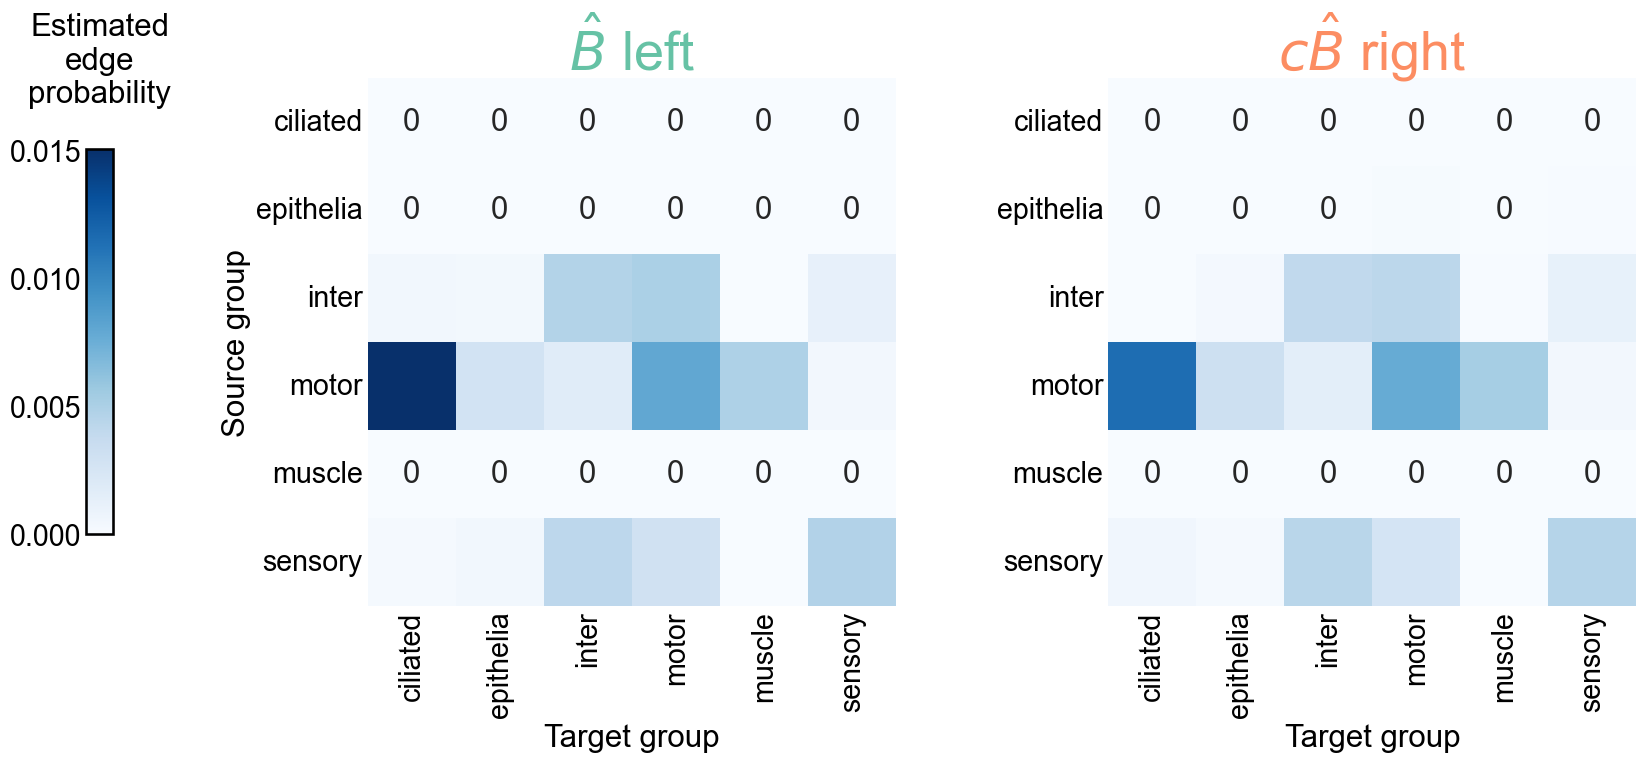

In [135]:
plot_stochastic_block_probabilities(misc_lr, network_palette, "left", "right")

In [136]:
lr_pvals = misc_lr["uncorrected_pvalues"]
lr_pvals


target,ciliated,epithelia,inter,motor,muscle,sensory
source,,,,,,
ciliated,NaN,NaN,NaN,NaN,NaN,NaN
epithelia,NaN,NaN,NaN,NaN,NaN,NaN
inter,0.007795,1.000000,0.000590,0.058986,0.220606,0.44882
motor,0.160210,0.752457,0.371297,1.000000,0.594024,1.00000
muscle,NaN,NaN,NaN,NaN,NaN,NaN
sensory,0.509687,0.415255,0.522288,0.461061,0.378468,1.00000


In [137]:
names = ["Sensory", "Inter", "Motor", "Muscle", "Epithelia", "Ciliated"]

def convert_misc_format_pval(pval_df):
    zero_data = np.zeros(shape=(len(names), len(names)))
    pval_df_convert = pd.DataFrame(zero_data, columns=names, index=names)
    for i in range(len(pval_df)):
        for j in range(len(pval_df.columns)):
            pval_df_convert[names[i]][names[j]] = pval_df[names[i].lower()][names[j].lower()]
    
    return pval_df_convert


lr_pvals.columns = lr_pvals.columns.str.capitalize()
lr_pvals.index = lr_pvals.index.str.capitalize()
lr_pvals

target,Ciliated,Epithelia,Inter,Motor,Muscle,Sensory
source,,,,,,
Ciliated,NaN,NaN,NaN,NaN,NaN,NaN
Epithelia,NaN,NaN,NaN,NaN,NaN,NaN
Inter,0.007795,1.000000,0.000590,0.058986,0.220606,0.44882
Motor,0.160210,0.752457,0.371297,1.000000,0.594024,1.00000
Muscle,NaN,NaN,NaN,NaN,NaN,NaN
Sensory,0.509687,0.415255,0.522288,0.461061,0.378468,1.00000


In [119]:
thres

1e-12

In [124]:
lr_df_convert = convert_misc_format_pval(lr_pvals)


KeyError: 'sensory'

In [139]:
lr_pvals

target,Ciliated,Epithelia,Inter,Motor,Muscle,Sensory
source,,,,,,
Ciliated,NaN,NaN,NaN,NaN,NaN,NaN
Epithelia,NaN,NaN,NaN,NaN,NaN,NaN
Inter,0.007795,1.000000,0.000590,0.058986,0.220606,0.44882
Motor,0.160210,0.752457,0.371297,1.000000,0.594024,1.00000
Muscle,NaN,NaN,NaN,NaN,NaN,NaN
Sensory,0.509687,0.415255,0.522288,0.461061,0.378468,1.00000


0.007795286874718172, -4.854235974748285
Inter, Ciliated

0.0005897287437109069, -7.43584788320709
Inter, Inter



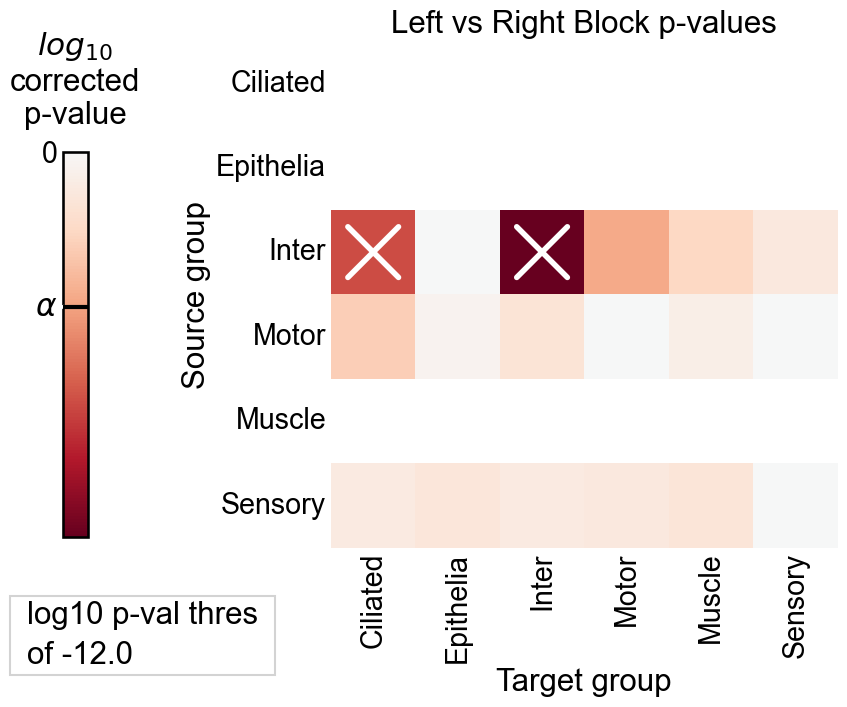

In [143]:
# lr_df_convert = convert_misc_format_pval(lr_pvals)


plot_pvals_v2(lr_pvals, title="Left vs Right Block p-values", thres = thres, check_diag = True)

(<Figure size 1000x1000 with 2 Axes>,
 <AxesSubplot:xlabel='Sorted group pairs', ylabel='$\\hat{p}_{left} - \\hat{p}_{right}$'>)

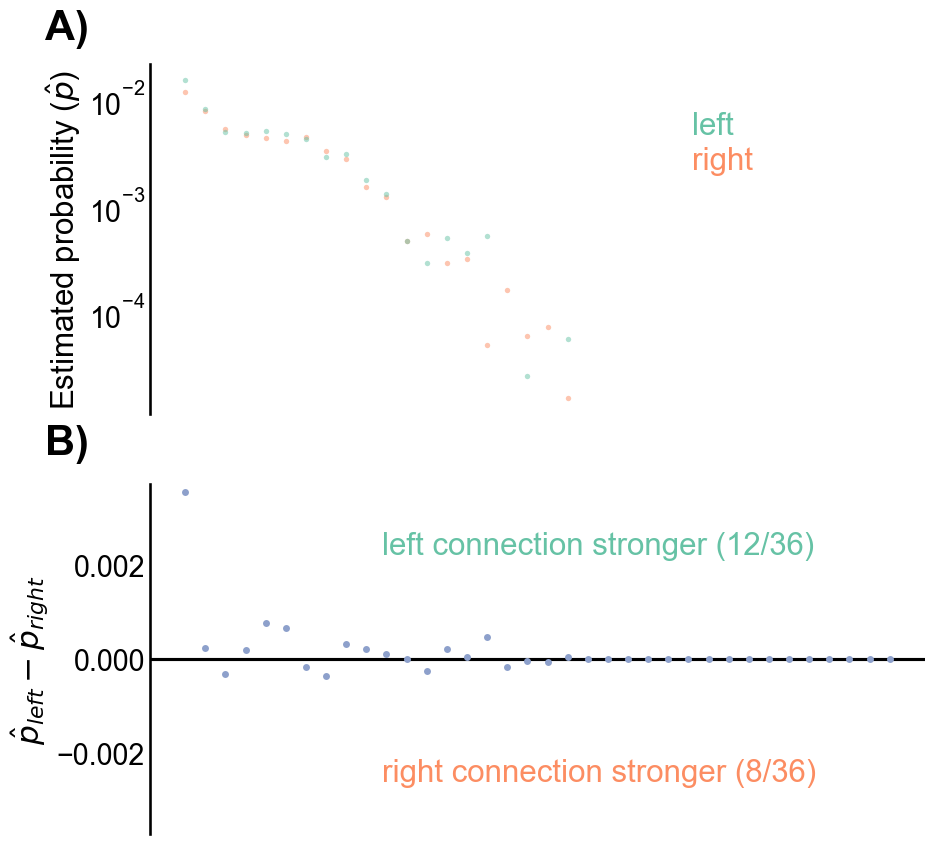

In [99]:
plot_estimated_probabilities(misc_lr, "left", "right")

head vs seg 1

In [100]:
np_head = np.array(head_adj)
np_seg1 = np.array(adj_1)
stat, pvalue, misc_h1 = group_connection_test(
    np_head,
    np_seg1,
    labels1=head_labels,
    labels2=labels_1,
    density_adjustment=True
)
print(misc_h1["probabilities1"])
print(misc_h1["probabilities2"])

target     ciliated  epithelia     inter     motor    muscle   sensory
source                                                                
ciliated   0.000000   0.000000  0.000000  0.000000  0.000000  0.000000
epithelia  0.000000   0.000000  0.000000  0.003125  0.000000  0.000000
inter      0.001566   0.001736  0.006832  0.018634  0.000890  0.000907
motor      0.105882   0.000000  0.006250  0.050000  0.011538  0.000800
muscle     0.000000   0.000000  0.000000  0.000000  0.000000  0.000000
sensory    0.000471   0.001000  0.004358  0.011067  0.000821  0.004870
target     ciliated  epithelia     inter     motor    muscle   sensory
source                                                                
ciliated   0.000000   0.000000  0.000000  0.000000  0.000000  0.000000
epithelia  0.000000   0.000000  0.000000  0.000000  0.000000  0.000000
inter      0.000000   0.000000  0.007120  0.008885  0.000085  0.002454
motor      0.032328   0.006158  0.003702  0.014519  0.020474  0.000985
muscle

In [101]:
#format B1 and B2
B1_h1, B2_h1 = convert_misc_format_prob(misc_h1)

#misc_h1_dup = misc_h1.copy()
#misc_h1_dup["probabilities1"] = B1_h1
#misc_h1_dup["probabilities2"] = B2_h1

(<Figure size 2000x1000 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Estimated\nedge\nprobability'}>,
        <AxesSubplot:>,
        <AxesSubplot:title={'center':'$\\hat{B}$ head'}, xlabel='Target group', ylabel='Source group'>,
        <AxesSubplot:>,
        <AxesSubplot:title={'center':'$c$$\\hat{B}$ segment 1'}, xlabel='Target group'>],
       dtype=object))

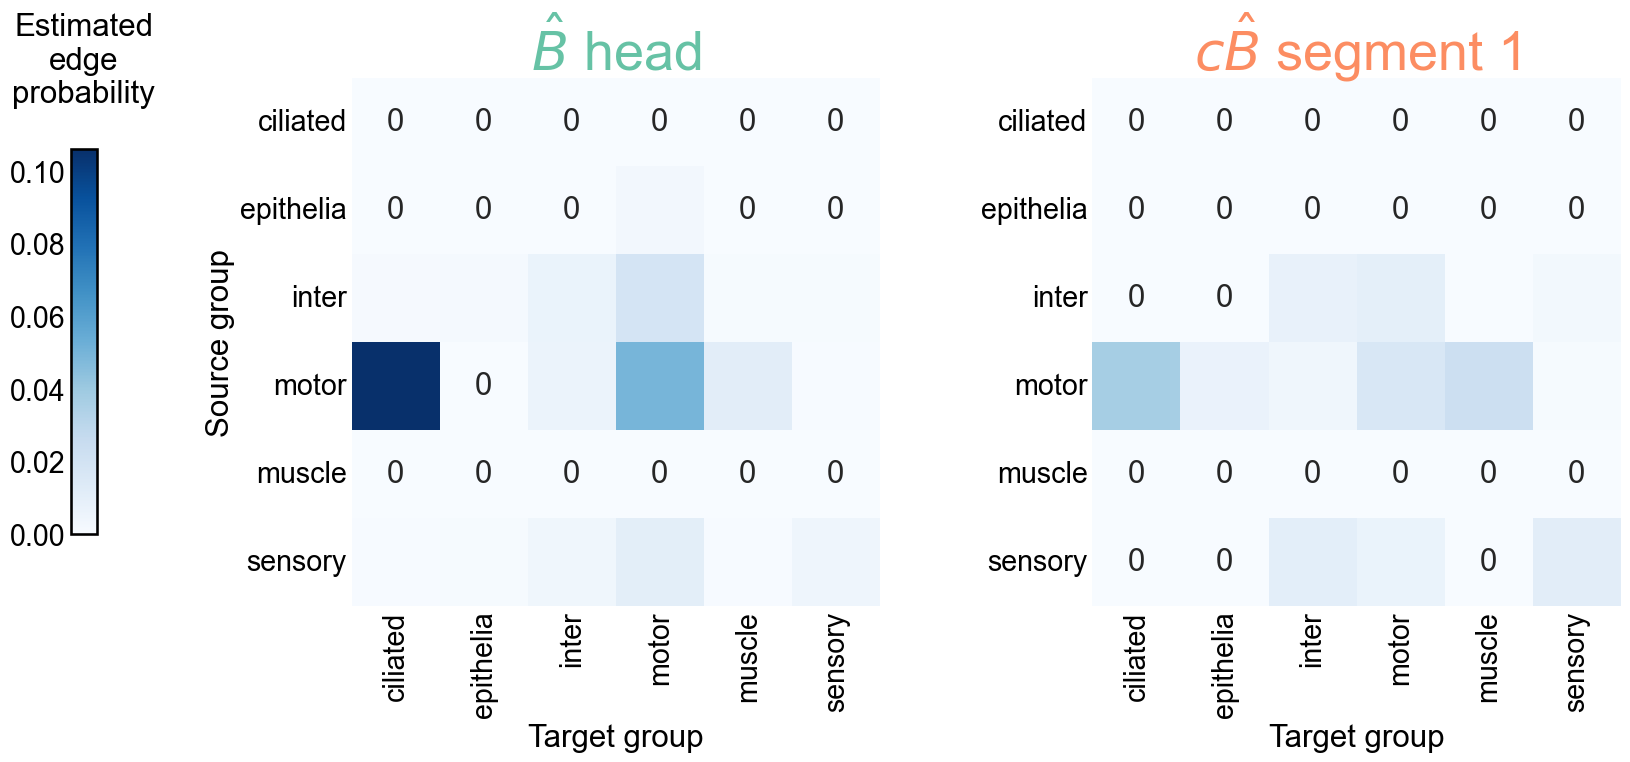

In [102]:
plot_stochastic_block_probabilities(misc_h1, network_palette, "head", "segment 1")

In [103]:
h1_pvals = misc_h1["uncorrected_pvalues"]
h1_pvals

target,ciliated,epithelia,inter,motor,muscle,sensory
source,,,,,,
ciliated,NaN,NaN,NaN,NaN,NaN,NaN
epithelia,NaN,NaN,NaN,NaN,NaN,NaN
inter,NaN,NaN,2.933701e-02,0.000003,0.006458,0.000374
motor,0.000027,NaN,7.146494e-02,0.000128,0.289644,0.654025
muscle,NaN,NaN,NaN,NaN,NaN,NaN
sensory,NaN,NaN,2.283367e-08,0.116079,NaN,0.006252


In [45]:
"""
h1_pvals_conv = h1_pvals.copy()
for rowIndex, row in h1_pvals.iterrows(): #iterate over rows
    for columnIndex, value in row.items(): 
        if value < thres:
            h1_pvals_conv[columnIndex][rowIndex] = thres
h1_pvals_conv
"""

'\nh1_pvals_conv = h1_pvals.copy()\nfor rowIndex, row in h1_pvals.iterrows(): #iterate over rows\n    for columnIndex, value in row.items(): \n        if value < thres:\n            h1_pvals_conv[columnIndex][rowIndex] = thres\nh1_pvals_conv\n'

0.006252324277815517, -5.074801999915228
Sensory, Sensory

0.00037380833186402866, -7.891767373560326
Sensory, Inter

2.2833672639704024e-08, -17.59502952032373
Inter, Sensory

0.029337006860157347, -3.528905527144146
Inter, Inter

3.2251898455416792e-06, -12.644518742614494
Motor, Inter

0.0001283253182797761, -8.960941969257775
Motor, Motor

0.006457597887717714, -5.0424978743452975
Muscle, Inter

2.703203510840785e-05, -10.518487909781012
Ciliated, Motor



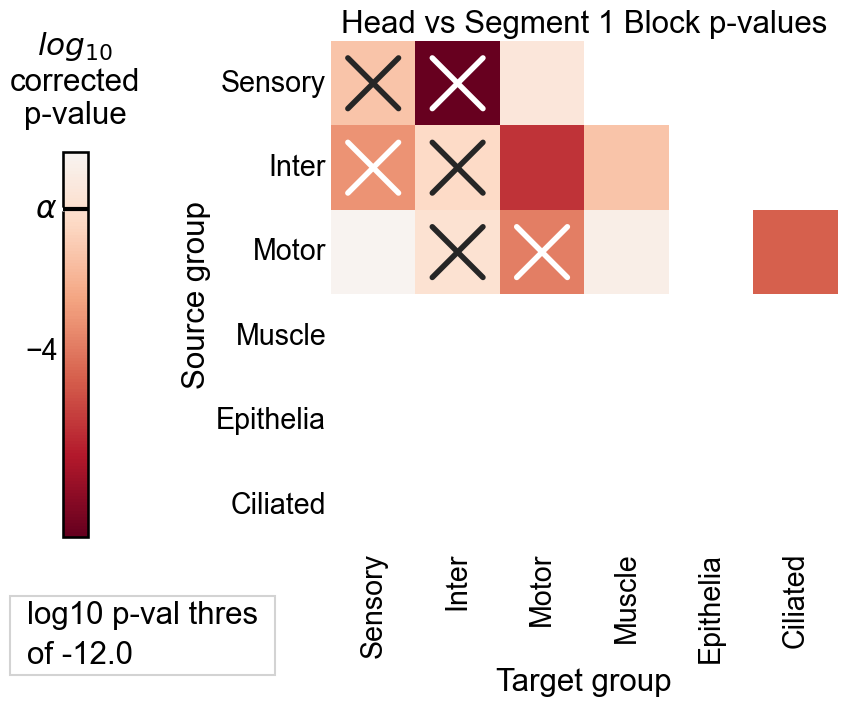

In [104]:
h1_df_convert = convert_misc_format_pval(h1_pvals)
plot_pvals_v2(h1_df_convert, names, title="Head vs Segment 1 Block p-values", thres=thres, check_diag=True)

(<Figure size 1000x1000 with 2 Axes>,
 <AxesSubplot:xlabel='Sorted group pairs', ylabel='$\\hat{p}_{left} - \\hat{p}_{right}$'>)

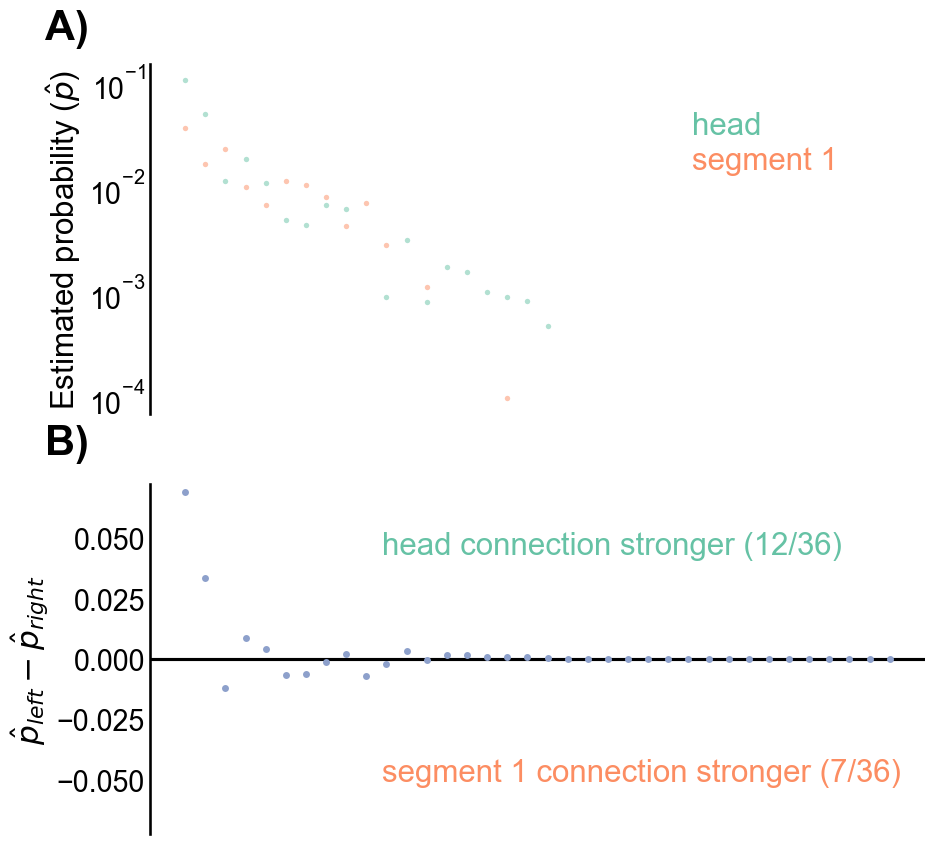

In [105]:
plot_estimated_probabilities(misc_h1, "head", "segment 1")

seg 1 vs seg 2

In [106]:
np_seg1 = np.array(adj_1)
np_seg2 = np.array(adj_2)
stat, pvalue, misc_12 = group_connection_test(
    np_seg1,
    np_seg2,
    labels1=labels_1,
    labels2=labels_2,
    density_adjustment=True
)

print(misc_12["probabilities1"])
print(misc_12["probabilities2"])

target     ciliated  epithelia     inter     motor    muscle   sensory
source                                                                
ciliated   0.000000   0.000000  0.000000  0.000000  0.000000  0.000000
epithelia  0.000000   0.000000  0.000000  0.000000  0.000000  0.000000
inter      0.000000   0.000000  0.007120  0.008885  0.000085  0.002454
motor      0.032328   0.006158  0.003702  0.014519  0.020474  0.000985
muscle     0.000000   0.000000  0.000000  0.000000  0.000000  0.000000
sensory    0.000000   0.000000  0.009290  0.005911  0.000000  0.010084
target     ciliated  epithelia     inter     motor    muscle   sensory
source                                                                
ciliated        0.0   0.000000  0.000000  0.000000  0.000000  0.000000
epithelia       0.0   0.000000  0.000000  0.000574  0.000000  0.000000
inter           0.0   0.000469  0.008365  0.009081  0.000066  0.002799
motor           0.0   0.007458  0.002671  0.011901  0.018876  0.002191
muscle

In [49]:
#format B1 and B2
B1_12, B2_12 = convert_misc_format_prob(misc_12)
#misc_12_dup = misc_12.copy()
#misc_12_dup["probabilities1"] = B1_12
#misc_12_dup["probabilities2"] = B2_12

(<Figure size 2000x1000 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Estimated\nedge\nprobability'}>,
        <AxesSubplot:>,
        <AxesSubplot:title={'center':'$\\hat{B}$ segment 1'}, xlabel='Target group', ylabel='Source group'>,
        <AxesSubplot:>,
        <AxesSubplot:title={'center':'$c$$\\hat{B}$ segment 2'}, xlabel='Target group'>],
       dtype=object))

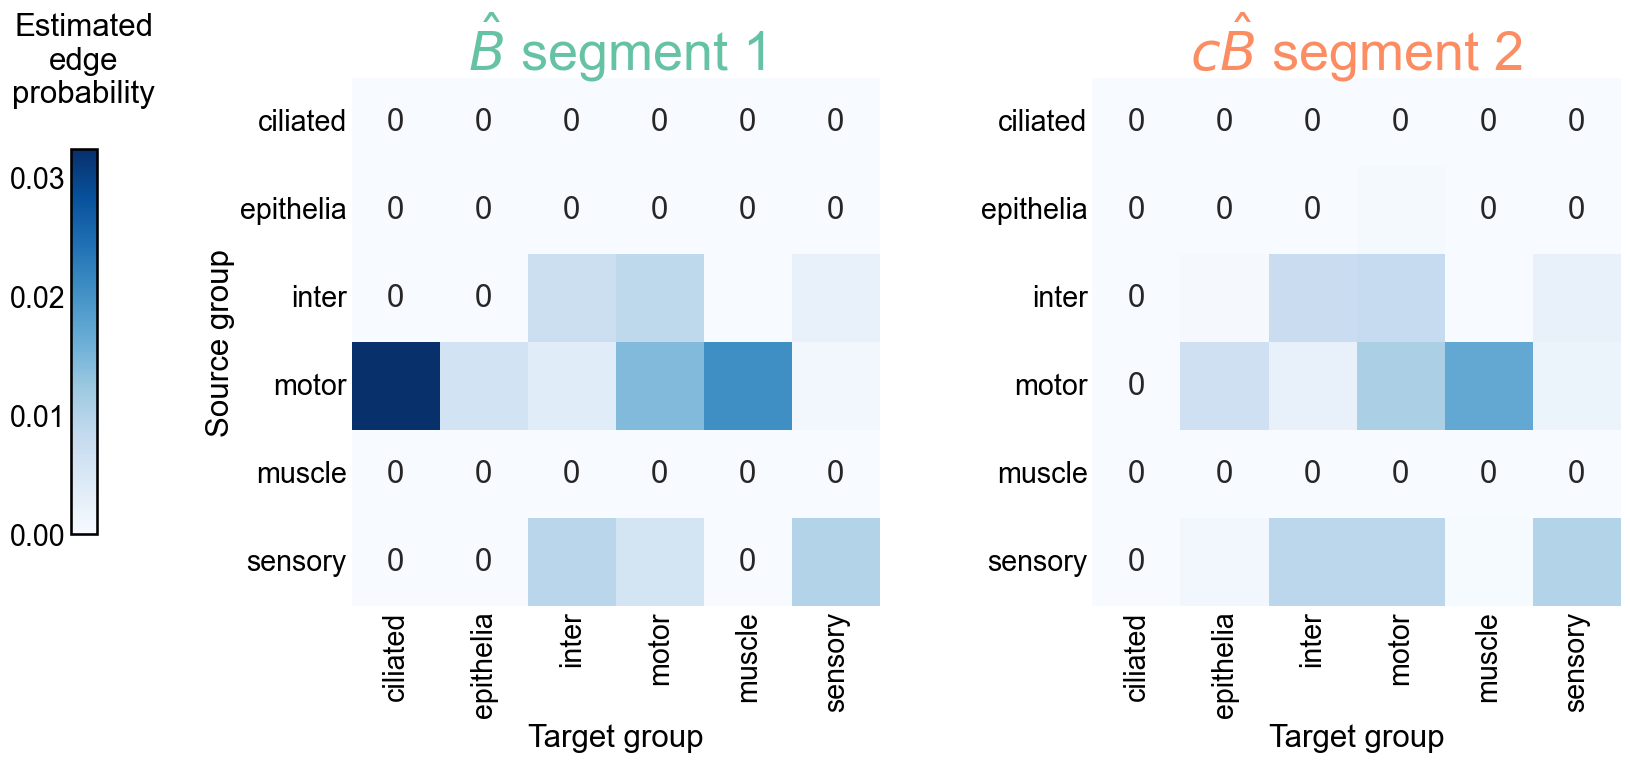

In [107]:
plot_stochastic_block_probabilities(misc_12, network_palette, "segment 1", "segment 2")

In [108]:
seg12_pvals = misc_12["uncorrected_pvalues"]
seg12_pvals

target,ciliated,epithelia,inter,motor,muscle,sensory
source,,,,,,
ciliated,NaN,NaN,NaN,NaN,NaN,NaN
epithelia,NaN,NaN,NaN,NaN,NaN,NaN
inter,NaN,NaN,0.527375,1.000000,1.000000,1.000000
motor,NaN,1.0,0.058309,0.101964,0.070406,0.511704
muscle,NaN,NaN,NaN,NaN,NaN,NaN
sensory,NaN,NaN,1.000000,0.223905,NaN,1.000000


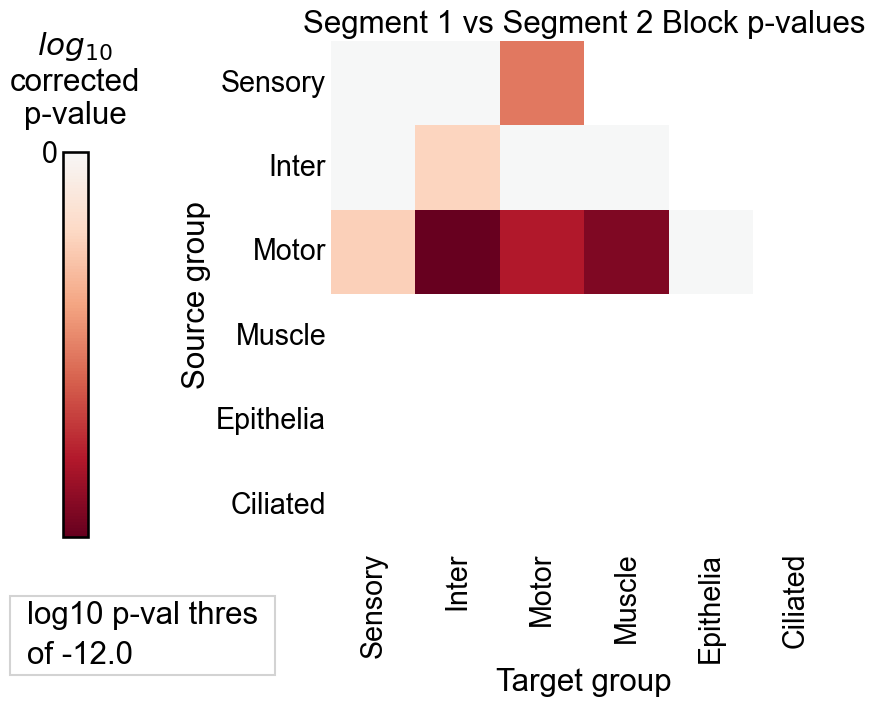

In [109]:
seg12_df_convert = convert_misc_format_pval(seg12_pvals)
plot_pvals(seg12_df_convert, names, title="Segment 1 vs Segment 2 Block p-values", thres=thres, check_diag=True)

(<Figure size 1000x1000 with 2 Axes>,
 <AxesSubplot:xlabel='Sorted group pairs', ylabel='$\\hat{p}_{left} - \\hat{p}_{right}$'>)

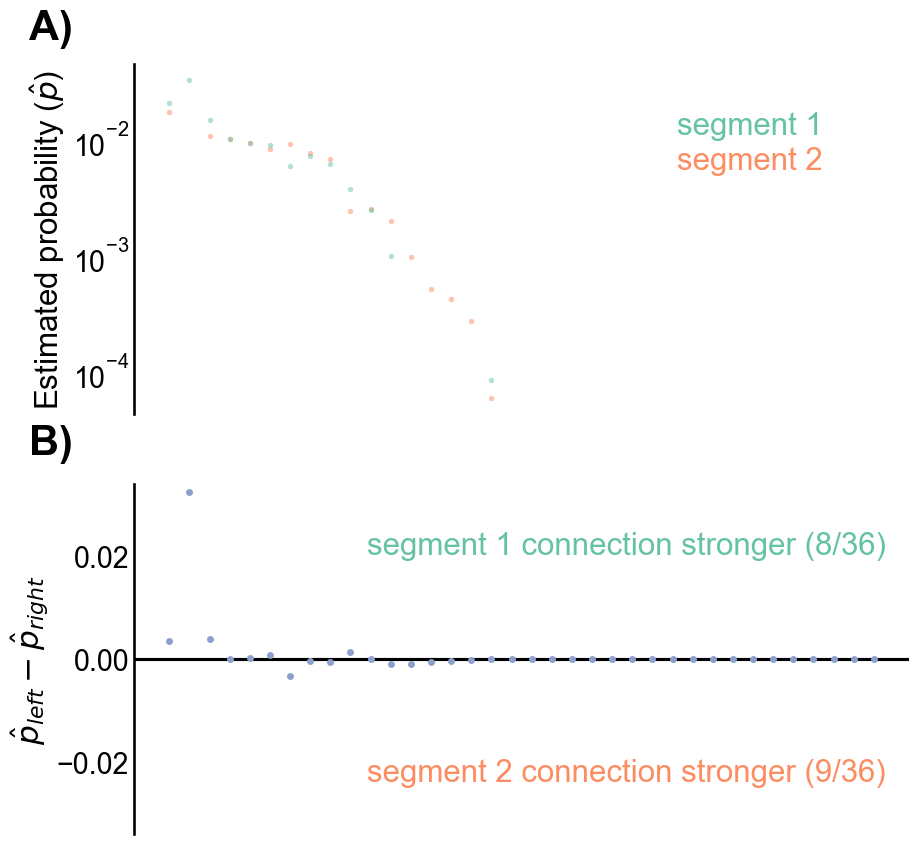

In [53]:
plot_estimated_probabilities(misc_12, "segment 1", "segment 2")

Fix colorbar everywhere (all heatmaps of pvalues in density/sbms)

Graph Matching:
Use weighted networks
param n_init: governs how many restarts to do
compute an accuracy compared to what nadine said
try in segment 1 vs segment 2


Something wrong with group_connection test pvals...? Because I am just taking the pvals from misc

Uncorrected vs corrected pvals

X's not showing in some places where they should

Use loc to index and rerun sbm tests

Fix colorbar to original version (have it consistent across all figs)

Change lab meeting to 5/15?

Get final figs and publish to overleaf

Work on presentation